# Weather Underground Data: Fetch → Clean → Check
## Complete Pipeline with Precipitation Focus

**Features:**
1. ✅ Fetch data with auto-chunking (64+ days)
2. ✅ Convert to clean column names (precipitation FIRST!)
3. ✅ Quality checks and validation
4. ✅ Precipitation-focused analysis
5. ✅ Export to multiple formats

**Date:** 2025-11-11

---
## 1. Setup & Configuration
---

In [1]:
# Core imports
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


# Column mapping

from wu_column_mapping import *
from wu_functions import *

print("✅ All imports successful!")

✅ All imports successful!


In [2]:

# ============================================================================
# CONFIGURATION
# ============================================================================

API_KEY     = ' '
STATION_IDS =   ["KNYNEWYO1805" , ]
START_DATE  =  datetime(2024, 1, 1)
END_DATE    =  datetime(2024, 1, 30)

UNITS       =  'm'       # 'm' for metric, 'e' for English
OUTPUT_DIR  = 'output'

FETCH_OPTIONS = {
    'current': False,
    'rapid': False,
    'historical': True,  # Use this for long date ranges
    'hourly'    : False,
    'daily'     : False,
}

print(f"✅ Configuration loaded")
print(f"   Stations: {STATION_IDS}")
print(f"   Date range: {START_DATE.date()} to {END_DATE.date()}")
print(f"   Days: {(END_DATE - START_DATE).days}")

✅ Configuration loaded
   Stations: ['KNYNEWYO1805']
   Date range: 2024-01-01 to 2024-01-30
   Days: 29


---
## 2. Fetch Data
---

In [3]:
print("🌦 FETCHING DATA...")
print("=" * 70)

start, end = validate_date_range(START_DATE, END_DATE)
fetch_start_time = datetime.now()

all_data = fetch_all_data(API_KEY, STATION_IDS, start, end, UNITS, FETCH_OPTIONS)

fetch_duration = (datetime.now() - fetch_start_time).total_seconds()

print("\n" + "=" * 70)
if all_data:
    print(f"✅ Fetched data in {fetch_duration:.1f}s")
    total_obs = sum(len(d.get('rapid', {}).get('observations', [])) for d in all_data.values())
    print(f"📊 Total observations: {total_obs}")
else:
    print("❌ No data fetched")

🌦 FETCHING DATA...

Fetching data for station: KNYNEWYO1805
  → Fetching historical data (2024-01-01 to 2024-01-30)...
    ✓ Historical data fetched (720 total observations)

✅ Fetched data in 0.9s
📊 Total observations: 720


---
## 3. Convert to DataFrame with Clean Names
**Precipitation columns come FIRST!**
---

In [4]:
if all_data:
    print("🔄 CONVERTING TO DATAFRAME WITH CLEAN NAMES")
    print("=" * 70)

    # Get data
    station_id = list(all_data.keys())[0]
    observations = all_data[station_id]['rapid']['observations']

    # Create DataFrame with original names
    df_raw = pd.json_normalize(observations)
    df_raw['obsTimeLocal'] = pd.to_datetime(df_raw['obsTimeLocal'])
    df_raw['obsTimeUtc'] = pd.to_datetime(df_raw['obsTimeUtc'])
    df_raw = df_raw.sort_values('obsTimeLocal').reset_index(drop=True)

    print(f"✅ Created df_raw: {len(df_raw)} rows, {len(df_raw.columns)} columns")
    print(f"\n📋 Original column names (first 10):")
    for i, col in enumerate(df_raw.columns[:10], 1):
        print(f"  {i:2d}. {col}")

    # Convert to clean names
    df_clean = convert_wu_columns(df_raw)

    print(f"\n✅ Created df_clean: {len(df_clean)} rows, {len(df_clean.columns)} columns")
    print(f"\n📋 Clean column names (PRECIPITATION FIRST!):")
    for i, col in enumerate(df_clean.columns[:15], 1):
        marker = "🌧️ " if 'precip' in col else "  "
        print(f"{marker}{i:2d}. {col}")

    # Create metadata
    metadata = create_metadata_df(df_clean)
    print(f"\n✅ Created metadata: {len(metadata)} columns documented")

    # Use df_clean as default df
    df = df_clean.copy()

    print("\n📦 Available DataFrames:")
    print("  • df_raw    : Original WU column names")
    print("  • df_clean  : Clean simple column names (precipitation first!)")
    print("  • df        : Copy of df_clean (for convenience)")
    print("  • metadata  : Column descriptions")
else:
    print("❌ No data to convert")

🔄 CONVERTING TO DATAFRAME WITH CLEAN NAMES
✅ Created df_raw: 720 rows, 37 columns

📋 Original column names (first 10):
   1. stationID
   2. tz
   3. obsTimeUtc
   4. obsTimeLocal
   5. epoch
   6. lat
   7. lon
   8. solarRadiationHigh
   9. uvHigh
  10. winddirAvg

✅ Created df_clean: 720 rows, 37 columns

📋 Clean column names (PRECIPITATION FIRST!):
🌧️  1. precip_rate
🌧️  2. precip_total
   3. time_local
   4. time_utc
   5. timestamp_unix
   6. station_id
   7. latitude
   8. longitude
   9. timezone
  10. temp_avg
  11. temp_high
  12. temp_low
  13. dewpoint_avg
  14. dewpoint_high
  15. dewpoint_low

✅ Created metadata: 37 columns documented

📦 Available DataFrames:
  • df_raw    : Original WU column names
  • df_clean  : Clean simple column names (precipitation first!)
  • df        : Copy of df_clean (for convenience)
  • metadata  : Column descriptions


---
## 4. Precipitation Analysis & Checker
---

In [5]:
df.head()

,precip_rate,precip_total,time_local,time_utc,timestamp_unix,station_id,latitude,longitude,timezone,temp_avg,...,wind_gust_avg,wind_gust_high,wind_gust_low,wind_direction_avg,pressure_max,pressure_min,pressure_trend,solar_radiation_high,uv_index_high,qc_status
0,0.0,0.0,2024-01-01 00:58:23,2024-01-01 05:58:23+00:00,1704088703,KNYNEWYO1805,40.638,-74.035,America/New_York,5,...,5,6,3,95.0,1016.26,1016.26,0.0,0.0,0.0,1
1,0.0,0.0,2024-01-01 01:58:22,2024-01-01 06:58:22+00:00,1704092302,KNYNEWYO1805,40.638,-74.035,America/New_York,5,...,4,6,3,104.0,1015.92,1015.92,0.0,0.0,0.0,1
2,0.0,0.0,2024-01-01 02:58:21,2024-01-01 07:58:21+00:00,1704095901,KNYNEWYO1805,40.638,-74.035,America/New_York,5,...,3,5,3,124.0,1015.92,1015.92,0.0,0.0,0.0,1
3,0.0,0.0,2024-01-01 03:59:21,2024-01-01 08:59:21+00:00,1704099561,KNYNEWYO1805,40.638,-74.035,America/New_York,5,...,2,4,0,109.0,1015.58,1015.24,0.0,0.0,0.0,1
4,0.0,0.0,2024-01-01 04:59:18,2024-01-01 09:59:18+00:00,1704103158,KNYNEWYO1805,40.638,-74.035,America/New_York,5,...,1,3,0,115.0,1015.58,1015.24,0.0,0.0,0.0,1


🔍 PRECIPITATION DATA ANALYSIS (HIGH CONTRAST)

✅ Found 2 precipitation column(s): ['precip_rate', 'precip_total']

📊 precip_rate:
  • Total values: 720
  • Non-zero: 99 (13.8%)
  • Min: 0.000
  • Max: 13.280
  • Sum: 165.170
  • Mean (non-zero): 1.668
  • Top 5 values: [np.float64(13.28), np.float64(9.4), np.float64(8.69), np.float64(7.9), np.float64(7.67)]

📊 precip_total:
  • Total values: 720
  • Non-zero: 253 (35.1%)
  • Min: 0.000
  • Max: 50.950
  • Sum: 1823.230
  • Mean (non-zero): 7.206
  • Top 5 values: [np.float64(50.95), np.float64(45.59), np.float64(36.63), np.float64(28.75), np.float64(23.22)]

📈 Creating HIGH CONTRAST precipitation plots...


/var/folders/9q/vrtjr2_56sjdhy0yx86b5bjr0000gn/T/ipykernel_7161/692075503.py:134: UserWarning: Glyph 128167 (\N{DROPLET}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/9q/vrtjr2_56sjdhy0yx86b5bjr0000gn/T/ipykernel_7161/692075503.py:134: UserWarning: Glyph 9748 (\N{UMBRELLA WITH RAIN DROPS}) missing from font(s) Arial.
  plt.tight_layout()
/Users/drorjac/miniforge3/envs/openmesh/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128167 (\N{DROPLET}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/drorjac/miniforge3/envs/openmesh/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9748 (\N{UMBRELLA WITH RAIN DROPS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


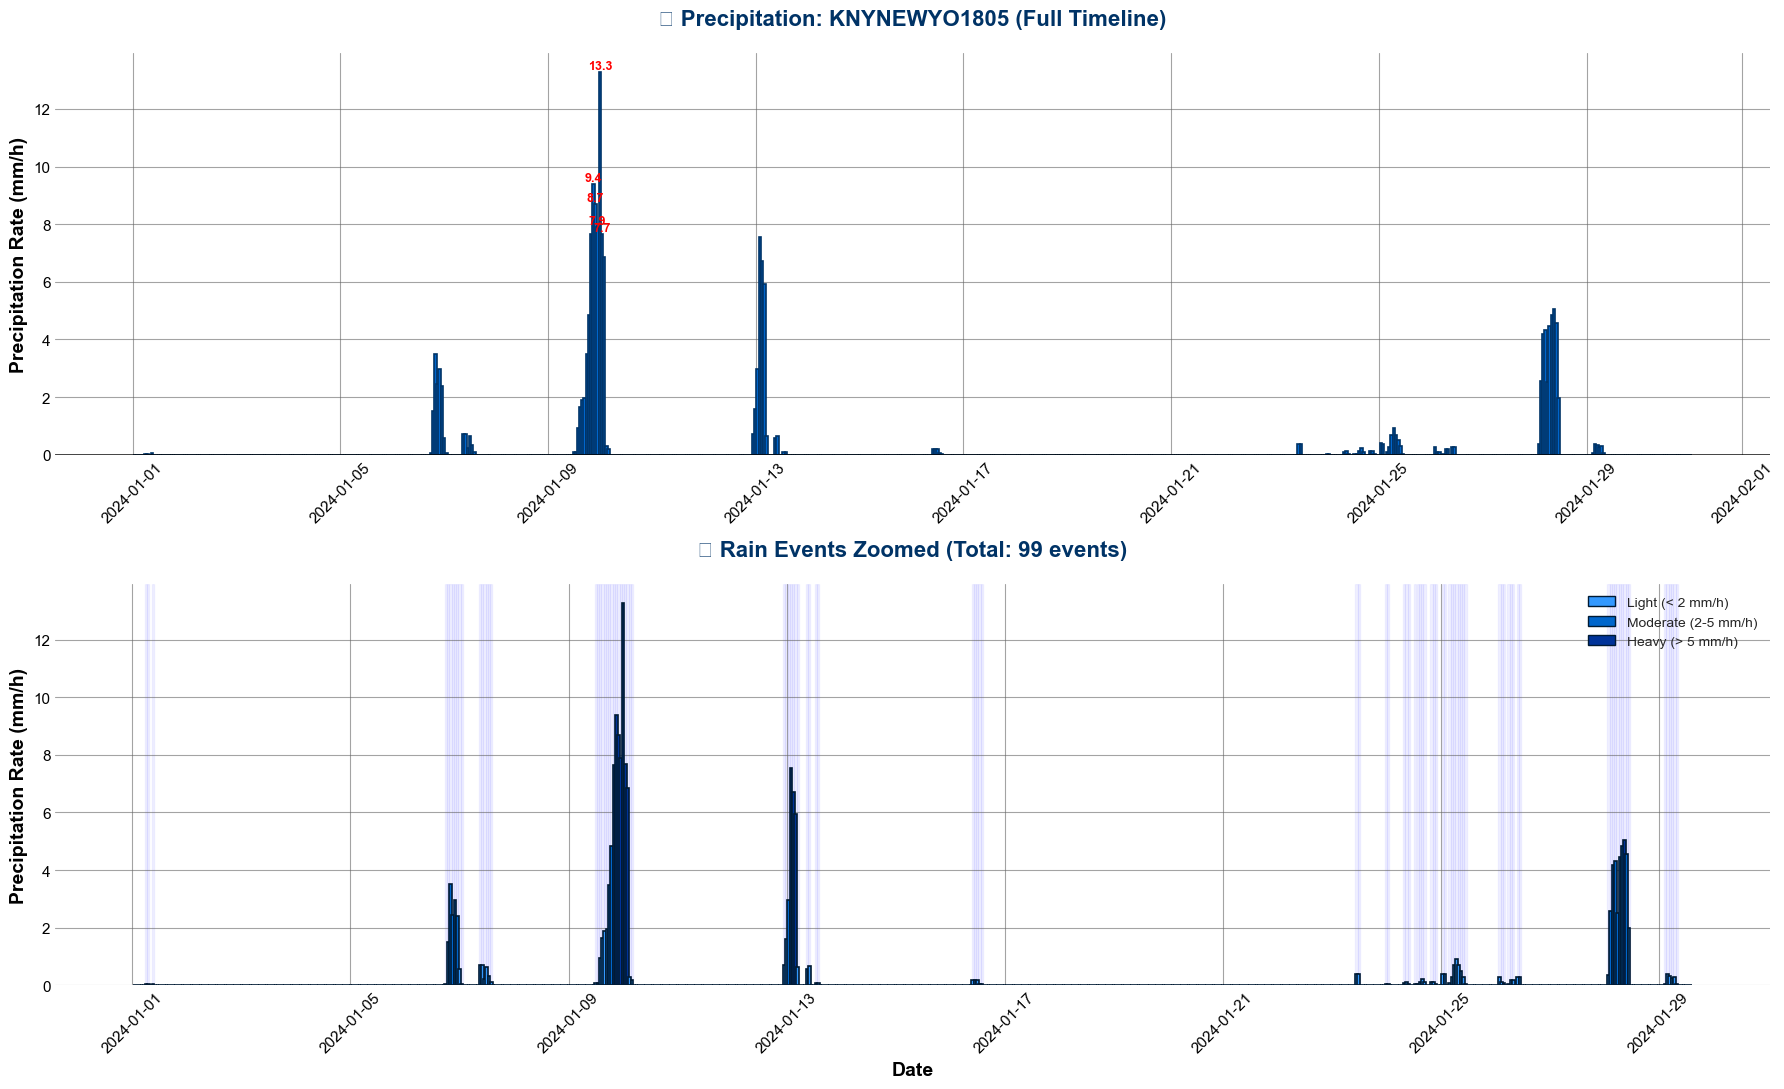


📊 PRECIPITATION STATISTICS
💧 Total precipitation: 165.17 mm/h
☔ Rain events: 99
📈 Max rate: 13.28 mm/h
📊 Mean rate (when raining): 1.67 mm/h

⏱️  First rain: 2024-01-01 05:59:18
⏱️  Last rain: 2024-01-29 07:58:45

📅 Daily Precipitation:
  • 2024-01-09: 61.84 mm/h
  • 2024-01-28: 34.83 mm/h
  • 2024-01-13: 25.18 mm/h
  • 2024-01-10: 15.03 mm/h
  • 2024-01-06: 13.46 mm/h
  • 2024-01-25: 4.28 mm/h
  • 2024-01-07: 2.77 mm/h
  • 2024-01-12: 2.31 mm/h
  • 2024-01-26: 1.45 mm/h
  • 2024-01-29: 1.36 mm/h

✅ Precipitation analysis complete!


In [6]:
# ============================================================================
# HIGH-CONTRAST PRECIPITATION VISUALIZATION
# Maximum visibility with strong colors
# ============================================================================

print("🔍 PRECIPITATION DATA ANALYSIS (HIGH CONTRAST)")
print("=" * 80)

if 'df' in locals() and len(df) > 0:

    # Check for precipitation columns
    precip_cols = [col for col in df.columns if 'precip' in col.lower()]

    if len(precip_cols) > 0:
        print(f"\n✅ Found {len(precip_cols)} precipitation column(s): {precip_cols}")

        # Analyze each column
        for col in precip_cols:
            values = df[col]
            non_zero = values[values > 0]

            print(f"\n📊 {col}:")
            print(f"  • Total values: {len(values)}")
            print(f"  • Non-zero: {len(non_zero)} ({len(non_zero)/len(values)*100:.1f}%)")
            print(f"  • Min: {values.min():.3f}")
            print(f"  • Max: {values.max():.3f}")
            print(f"  • Sum: {values.sum():.3f}")

            if len(non_zero) > 0:
                print(f"  • Mean (non-zero): {non_zero.mean():.3f}")
                print(f"  • Top 5 values: {sorted(non_zero.values, reverse=True)[:5]}")

        # HIGH CONTRAST VISUALIZATION
        print("\n📈 Creating HIGH CONTRAST precipitation plots...")

        precip_col = 'precip_rate' if 'precip_rate' in df.columns else precip_cols[0]
        unit = 'mm/h' if UNITS == 'm' else 'in/h'

        if df[precip_col].max() > 0:
            # HAS PRECIPITATION - Create HIGHLY VISIBLE plots
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 11))

            # Plot 1: Full timeline with STRONG COLORS
            ax1.bar(df['time_local'], df[precip_col],
                   width=0.05,                      # Slightly wider bars
                   color='#0066CC',                 # Strong deep blue
                   edgecolor='#003366',             # Very dark blue edge
                   alpha=1.0,                       # FULLY OPAQUE
                   linewidth=1.2)                   # Thicker edges

            ax1.set_ylabel(f'Precipitation Rate ({unit})',
                          fontweight='bold', fontsize=14, color='black')
            ax1.set_title(f'💧 Precipitation: {STATION_IDS[0]} (Full Timeline)',
                         fontsize=16, fontweight='bold', color='#003366', pad=20)

            # White background for maximum contrast
            ax1.set_facecolor('white')
            fig.patch.set_facecolor('white')

            # Strong grid
            ax1.grid(True, alpha=0.6, color='#666666', linestyle='-', linewidth=0.8)
            ax1.tick_params(axis='x', rotation=45, labelsize=11, colors='black')
            ax1.tick_params(axis='y', labelsize=11, colors='black')

            # Bold zero line
            ax1.axhline(y=0, color='black', linewidth=2, alpha=0.8)

            # Add value labels on highest bars
            max_vals = df[precip_col].nlargest(5)
            for idx in max_vals.index:
                ax1.text(df.loc[idx, 'time_local'], df.loc[idx, precip_col],
                        f'{df.loc[idx, precip_col]:.1f}',
                        ha='center', va='bottom', fontsize=9, fontweight='bold', color='red')

            # Plot 2: Zoomed to rain events with EVEN STRONGER COLOR
            rain_events = df[df[precip_col] > 0]

            if len(rain_events) > 0:
                margin = pd.Timedelta(hours=6)
                start_time = rain_events['time_local'].min() - margin
                end_time = rain_events['time_local'].max() + margin
                zoomed_df = df[(df['time_local'] >= start_time) & (df['time_local'] <= end_time)]

                # Use gradient colors based on intensity
                colors = []
                for val in zoomed_df[precip_col]:
                    if val == 0:
                        colors.append('#CCCCCC')  # Light gray for zero
                    elif val < 2:
                        colors.append('#3399FF')  # Light blue for light rain
                    elif val < 5:
                        colors.append('#0066CC')  # Medium blue for moderate
                    else:
                        colors.append('#003399')  # Dark blue for heavy

                ax2.bar(zoomed_df['time_local'], zoomed_df[precip_col],
                       width=0.05,
                       color=colors,                    # Color by intensity
                       edgecolor='#001a33',             # Very dark edge
                       alpha=1.0,                       # FULLY OPAQUE
                       linewidth=1.2)

                ax2.set_ylabel(f'Precipitation Rate ({unit})',
                              fontweight='bold', fontsize=14, color='black')
                ax2.set_xlabel('Date', fontweight='bold', fontsize=14, color='black')
                ax2.set_title(f'☔ Rain Events Zoomed (Total: {len(rain_events)} events)',
                             fontsize=16, fontweight='bold', color='#003366', pad=20)

                ax2.set_facecolor('white')
                ax2.grid(True, alpha=0.6, color='#666666', linestyle='-', linewidth=0.8)
                ax2.tick_params(axis='x', rotation=45, labelsize=11, colors='black')
                ax2.tick_params(axis='y', labelsize=11, colors='black')

                # Add legend for colors
                from matplotlib.patches import Patch
                legend_elements = [
                    Patch(facecolor='#3399FF', edgecolor='#001a33', label='Light (< 2 mm/h)'),
                    Patch(facecolor='#0066CC', edgecolor='#001a33', label='Moderate (2-5 mm/h)'),
                    Patch(facecolor='#003399', edgecolor='#001a33', label='Heavy (> 5 mm/h)')
                ]
                ax2.legend(handles=legend_elements, loc='upper right', fontsize=10)

                # Highlight periods with rain
                rain_times = zoomed_df[zoomed_df[precip_col] > 0]['time_local']
                for t in rain_times:
                    ax2.axvspan(t - pd.Timedelta(minutes=30),
                               t + pd.Timedelta(minutes=30),
                               alpha=0.05, color='blue', zorder=0)
            else:
                ax2.text(0.5, 0.5, 'No precipitation events to zoom',
                        ha='center', va='center', transform=ax2.transAxes,
                        fontsize=16, fontweight='bold', color='#003366')

            plt.tight_layout()
            plt.show()

            # DETAILED STATISTICS
            print(f"\n" + "=" * 80)
            print(f"📊 PRECIPITATION STATISTICS")
            print("=" * 80)
            print(f"💧 Total precipitation: {df[precip_col].sum():.2f} {unit}")
            print(f"☔ Rain events: {len(rain_events)}")
            print(f"📈 Max rate: {df[precip_col].max():.2f} {unit}")
            print(f"📊 Mean rate (when raining): {rain_events[precip_col].mean():.2f} {unit}")

            if len(rain_events) > 0:
                print(f"\n⏱️  First rain: {rain_events['time_local'].min()}")
                print(f"⏱️  Last rain: {rain_events['time_local'].max()}")

                # Daily totals
                print(f"\n📅 Daily Precipitation:")
                daily = df.groupby(df['time_local'].dt.date)[precip_col].sum().sort_values(ascending=False)
                for date, total in daily.head(10).items():
                    if total > 0:
                        print(f"  • {date}: {total:.2f} {unit}")

        else:
            # NO PRECIPITATION - Create CLEAR informative plot
            fig, ax = plt.subplots(figsize=(18, 7))

            # Plot ALL zeros with visible gray bars
            ax.bar(df['time_local'], [0.5] * len(df),  # Show small bars at 0.5
                   width=0.05,
                   color='#DDDDDD',           # Light gray
                   edgecolor='#999999',       # Medium gray edge
                   alpha=0.7,
                   linewidth=0.8)

            # Bold zero line
            ax.axhline(y=0, color='red', linestyle='-', linewidth=4, alpha=0.8, zorder=5)

            # HUGE warning box
            ax.text(df['time_local'].iloc[len(df)//2], 2.5,
                   '⚠️ NO PRECIPITATION RECORDED ⚠️\n\nZero rainfall throughout the entire period',
                   ha='center', va='center',
                   fontsize=20, fontweight='bold',
                   color='red',
                   bbox=dict(boxstyle='round,pad=1.5',
                            facecolor='#FFFF99',  # Bright yellow
                            edgecolor='red',
                            linewidth=4,
                            alpha=0.95))

            ax.set_ylabel(f'Precipitation Rate ({unit})',
                         fontweight='bold', fontsize=14, color='black')
            ax.set_xlabel('Date', fontweight='bold', fontsize=14, color='black')
            ax.set_title(f'💧 Precipitation: {STATION_IDS[0]} - DRY PERIOD',
                        fontsize=16, fontweight='bold', color='red', pad=20)

            ax.set_facecolor('white')
            fig.patch.set_facecolor('white')
            ax.grid(True, alpha=0.4, color='#999999', linestyle='--', linewidth=0.8)
            ax.tick_params(axis='x', rotation=45, labelsize=11, colors='black')
            ax.tick_params(axis='y', labelsize=11, colors='black')

            # Set y-axis to show the message clearly
            ax.set_ylim(-0.5, 5)

            plt.tight_layout()
            plt.show()

            print("\n" + "=" * 80)
            print("⚠️  DRY PERIOD - NO PRECIPITATION DETECTED")
            print("=" * 80)
            print(f"\n📅 Period: {df['time_local'].min().date()} to {df['time_local'].max().date()}")
            print(f"📊 Total observations: {len(df)}")
            print(f"💧 Total rainfall: 0.00 {unit}")
            print("\n📋 Possible explanations:")
            print("  1. Natural dry period (no rain)")
            print("  2. Station lacks rain gauge equipment")
            print("  3. Rain sensor malfunction")
            print("  4. Data collection gap")

    else:
        print("\n❌ No precipitation columns found in DataFrame")
        print("\n📋 Available columns:")
        for i, col in enumerate(df.columns, 1):
            print(f"  {i:2d}. {col}")
else:
    print("\n❌ No DataFrame available")
    print("Please run the data fetching and conversion cells first!")

print("\n" + "=" * 80)
print("✅ Precipitation analysis complete!")
print("=" * 80)

📈 CUMULATIVE PRECIPITATION ANALYSIS

✅ Found precipitation columns: ['precip_rate', 'precip_total']

📊 Available data:
  • precip_rate (intensity):  ✅
  • precip_total (per-hour):  ✅

💧 Cumulative Precipitation Statistics:
  • Total accumulated: 165.17 mm
  • Average daily rate: 5.70 mm/day
  • Rain events: 99
  • Percentage of time raining: 13.8%


/var/folders/9q/vrtjr2_56sjdhy0yx86b5bjr0000gn/T/ipykernel_7161/521266336.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/Users/drorjac/miniforge3/envs/openmesh/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128167 (\N{DROPLET}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


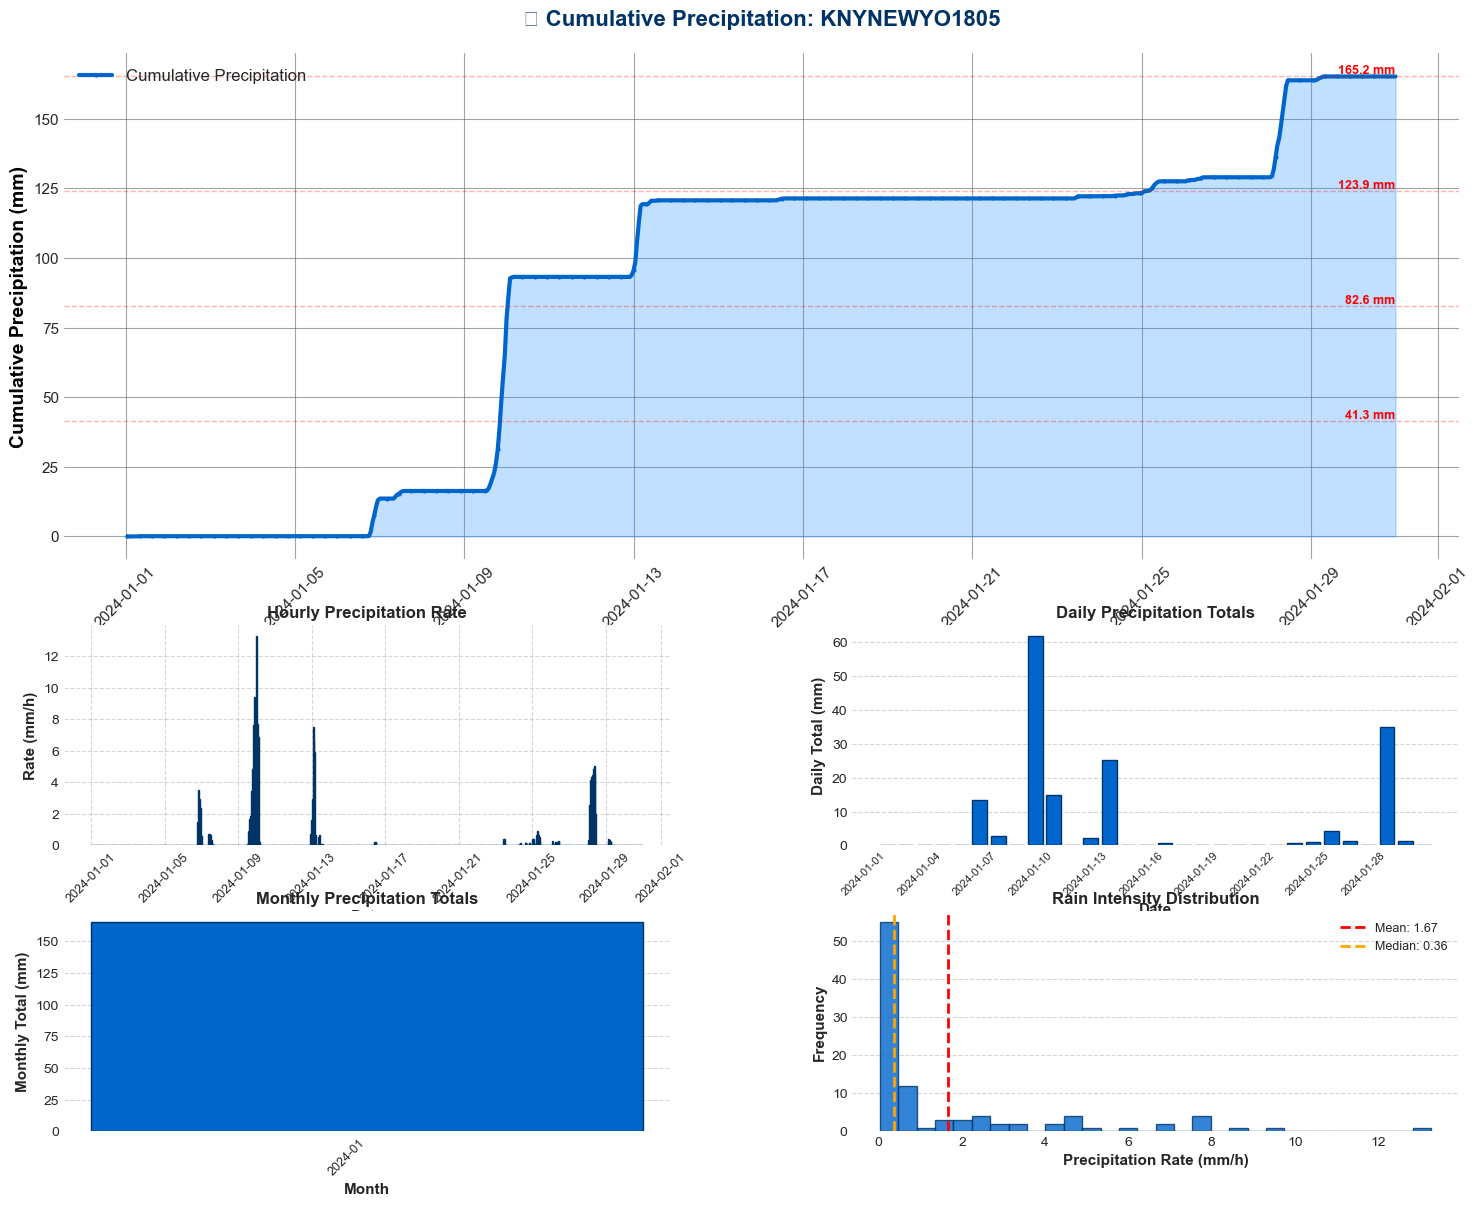


📊 DETAILED STATISTICS

🌧️  OVERALL:
  • Total accumulated: 165.17 mm
  • Period: 2024-01-01 to 2024-01-30
  • Days: 29

📈 RATES:
  • Max hourly rate: 13.28 mm/h
  • Average rate (when raining): 1.67 mm/h
  • Average daily total: 5.70 mm/day

☔ RAIN EVENTS:
  • Total rain hours: 99
  • Percentage of time: 13.8%

📅 DAILY BREAKDOWN:
  • Days with rain: 14
  • Wettest day: 61.84 mm on 2024-01-09
  • Average rain per rainy day: 11.80 mm

📆 MONTHLY BREAKDOWN:
  • 2024-01: 165.17 mm

✅ Cumulative analysis complete!


In [7]:
# ============================================================================
# CUMULATIVE PRECIPITATION PLOTS
# Shows total accumulated rainfall over time
# ============================================================================

print("📈 CUMULATIVE PRECIPITATION ANALYSIS")
print("=" * 80)

if 'df' in locals() and len(df) > 0:

    # Check for precipitation columns
    precip_cols = [col for col in df.columns if 'precip' in col.lower()]

    if len(precip_cols) > 0:
        print(f"\n✅ Found precipitation columns: {precip_cols}")

        # Determine which columns to use
        has_rate = 'precip_rate' in df.columns
        has_total = 'precip_total' in df.columns

        print(f"\n📊 Available data:")
        print(f"  • precip_rate (intensity):  {'✅' if has_rate else '❌'}")
        print(f"  • precip_total (per-hour):  {'✅' if has_total else '❌'}")

        # Create cumulative sum
        if has_rate or has_total:
            # Use rate if available, otherwise total
            precip_col = 'precip_rate' if has_rate else 'precip_total'

            # Calculate cumulative sum
            df_plot = df.copy()
            df_plot['cumulative_precip'] = df_plot[precip_col].cumsum()

            unit = 'mm' if UNITS == 'm' else 'in'

            print(f"\n💧 Cumulative Precipitation Statistics:")
            print(f"  • Total accumulated: {df_plot['cumulative_precip'].iloc[-1]:.2f} {unit}")
            print(f"  • Average daily rate: {df_plot['cumulative_precip'].iloc[-1] / ((df_plot['time_local'].max() - df_plot['time_local'].min()).days):.2f} {unit}/day")

            # Count rain events
            rain_events = df_plot[df_plot[precip_col] > 0]
            print(f"  • Rain events: {len(rain_events)}")
            print(f"  • Percentage of time raining: {len(rain_events)/len(df_plot)*100:.1f}%")

            # CREATE COMPREHENSIVE PLOTS
            fig = plt.figure(figsize=(18, 14))
            gs = fig.add_gridspec(4, 2, hspace=0.3, wspace=0.3)

            # ================================================================
            # PLOT 1: MAIN CUMULATIVE PLOT (spans 2 columns)
            # ================================================================
            ax1 = fig.add_subplot(gs[0:2, :])

            # Line plot with area fill
            ax1.plot(df_plot['time_local'], df_plot['cumulative_precip'],
                    linewidth=3, color='#0066CC', label='Cumulative Precipitation',
                    marker='o', markersize=2, markevery=max(1, len(df_plot)//100))

            ax1.fill_between(df_plot['time_local'], 0, df_plot['cumulative_precip'],
                            alpha=0.3, color='#3399FF')

            ax1.set_ylabel(f'Cumulative Precipitation ({unit})',
                          fontweight='bold', fontsize=14, color='black')
            ax1.set_title(f'💧 Cumulative Precipitation: {STATION_IDS[0]}',
                         fontsize=16, fontweight='bold', color='#003366', pad=20)

            ax1.set_facecolor('white')
            ax1.grid(True, alpha=0.6, color='#666666', linestyle='-', linewidth=0.8)
            ax1.tick_params(axis='x', rotation=45, labelsize=11)
            ax1.tick_params(axis='y', labelsize=11)
            ax1.legend(loc='upper left', fontsize=12, framealpha=0.9)

            # Add milestones
            max_cum = df_plot['cumulative_precip'].max()
            if max_cum > 0:
                for milestone in [max_cum * 0.25, max_cum * 0.5, max_cum * 0.75, max_cum]:
                    ax1.axhline(y=milestone, color='red', linestyle='--',
                               alpha=0.3, linewidth=1)
                    ax1.text(df_plot['time_local'].iloc[-1], milestone,
                            f'{milestone:.1f} {unit}',
                            ha='right', va='bottom', fontsize=9,
                            color='red', fontweight='bold')

            # ================================================================
            # PLOT 2: HOURLY RATE (left bottom)
            # ================================================================
            ax2 = fig.add_subplot(gs[2, 0])

            ax2.bar(df_plot['time_local'], df_plot[precip_col],
                   width=0.05, color='#0066CC', edgecolor='#003366',
                   alpha=1.0, linewidth=1)

            ax2.set_ylabel(f'Rate ({unit}/h)', fontweight='bold', fontsize=11)
            ax2.set_xlabel('Date', fontweight='bold', fontsize=11)
            ax2.set_title('Hourly Precipitation Rate', fontsize=12, fontweight='bold')
            ax2.set_facecolor('white')
            ax2.grid(True, alpha=0.4, color='#999999', linestyle='--')
            ax2.tick_params(axis='x', rotation=45, labelsize=9)

            # ================================================================
            # PLOT 3: DAILY ACCUMULATION (right bottom)
            # ================================================================
            ax3 = fig.add_subplot(gs[2, 1])

            daily_precip = df_plot.groupby(df_plot['time_local'].dt.date)[precip_col].sum()

            ax3.bar(range(len(daily_precip)), daily_precip.values,
                   color='#0066CC', edgecolor='#003366', alpha=1.0, linewidth=1)

            ax3.set_ylabel(f'Daily Total ({unit})', fontweight='bold', fontsize=11)
            ax3.set_xlabel('Date', fontweight='bold', fontsize=11)
            ax3.set_title('Daily Precipitation Totals', fontsize=12, fontweight='bold')
            ax3.set_facecolor('white')
            ax3.grid(True, alpha=0.4, color='#999999', linestyle='--', axis='y')

            # Set x-ticks to show dates
            tick_positions = range(0, len(daily_precip), max(1, len(daily_precip)//10))
            ax3.set_xticks(tick_positions)
            ax3.set_xticklabels([str(daily_precip.index[i]) for i in tick_positions],
                               rotation=45, ha='right', fontsize=8)

            # ================================================================
            # PLOT 4: CUMULATIVE BY MONTH (left bottom)
            # ================================================================
            ax4 = fig.add_subplot(gs[3, 0])

            df_plot['year_month'] = df_plot['time_local'].dt.to_period('M')
            monthly_precip = df_plot.groupby('year_month')[precip_col].sum()

            ax4.bar(range(len(monthly_precip)), monthly_precip.values,
                   color='#0066CC', edgecolor='#003366', alpha=1.0, linewidth=1)

            ax4.set_ylabel(f'Monthly Total ({unit})', fontweight='bold', fontsize=11)
            ax4.set_xlabel('Month', fontweight='bold', fontsize=11)
            ax4.set_title('Monthly Precipitation Totals', fontsize=12, fontweight='bold')
            ax4.set_facecolor('white')
            ax4.grid(True, alpha=0.4, color='#999999', linestyle='--', axis='y')

            ax4.set_xticks(range(len(monthly_precip)))
            ax4.set_xticklabels([str(m) for m in monthly_precip.index],
                               rotation=45, ha='right', fontsize=9)

            # ================================================================
            # PLOT 5: RAIN EVENT INTENSITY DISTRIBUTION (right bottom)
            # ================================================================
            ax5 = fig.add_subplot(gs[3, 1])

            rain_only = df_plot[df_plot[precip_col] > 0][precip_col]

            if len(rain_only) > 0:
                ax5.hist(rain_only, bins=30, color='#0066CC',
                        edgecolor='#003366', alpha=0.8, linewidth=1)

                ax5.set_ylabel('Frequency', fontweight='bold', fontsize=11)
                ax5.set_xlabel(f'Precipitation Rate ({unit}/h)', fontweight='bold', fontsize=11)
                ax5.set_title('Rain Intensity Distribution', fontsize=12, fontweight='bold')
                ax5.set_facecolor('white')
                ax5.grid(True, alpha=0.4, color='#999999', linestyle='--', axis='y')

                # Add statistics
                ax5.axvline(rain_only.mean(), color='red', linestyle='--',
                           linewidth=2, label=f'Mean: {rain_only.mean():.2f}')
                ax5.axvline(rain_only.median(), color='orange', linestyle='--',
                           linewidth=2, label=f'Median: {rain_only.median():.2f}')
                ax5.legend(fontsize=9)
            else:
                ax5.text(0.5, 0.5, 'No rain events', ha='center', va='center',
                        transform=ax5.transAxes, fontsize=12, fontweight='bold')

            plt.tight_layout()
            plt.show()

            # ================================================================
            # DETAILED STATISTICS TABLE
            # ================================================================
            print("\n" + "=" * 80)
            print("📊 DETAILED STATISTICS")
            print("=" * 80)

            print(f"\n🌧️  OVERALL:")
            print(f"  • Total accumulated: {df_plot['cumulative_precip'].iloc[-1]:.2f} {unit}")
            print(f"  • Period: {df_plot['time_local'].min().date()} to {df_plot['time_local'].max().date()}")
            print(f"  • Days: {(df_plot['time_local'].max() - df_plot['time_local'].min()).days}")

            print(f"\n📈 RATES:")
            print(f"  • Max hourly rate: {df_plot[precip_col].max():.2f} {unit}/h")
            print(f"  • Average rate (when raining): {rain_events[precip_col].mean():.2f} {unit}/h" if len(rain_events) > 0 else "  • No rain events")
            print(f"  • Average daily total: {df_plot['cumulative_precip'].iloc[-1] / ((df_plot['time_local'].max() - df_plot['time_local'].min()).days):.2f} {unit}/day")

            print(f"\n☔ RAIN EVENTS:")
            print(f"  • Total rain hours: {len(rain_events)}")
            print(f"  • Percentage of time: {len(rain_events)/len(df_plot)*100:.1f}%")

            if len(daily_precip[daily_precip > 0]) > 0:
                print(f"\n📅 DAILY BREAKDOWN:")
                print(f"  • Days with rain: {len(daily_precip[daily_precip > 0])}")
                print(f"  • Wettest day: {daily_precip.max():.2f} {unit} on {daily_precip.idxmax()}")
                print(f"  • Average rain per rainy day: {daily_precip[daily_precip > 0].mean():.2f} {unit}")

            if len(monthly_precip) > 0:
                print(f"\n📆 MONTHLY BREAKDOWN:")
                for month, total in monthly_precip.items():
                    print(f"  • {month}: {total:.2f} {unit}")

        else:
            print("\n❌ No precipitation data columns found")

    else:
        print("\n❌ No precipitation columns in DataFrame")

else:
    print("\n❌ No DataFrame available")

print("\n" + "=" * 80)
print("✅ Cumulative analysis complete!")
print("=" * 80)

---
## 5. Data Quality Checks
---

In [8]:
if 'df' in locals() and len(df) > 0:
    print("🔍 DATA QUALITY CHECKS")
    print("=" * 70)
    
    # Date range
    first_date = df['time_local'].min()
    last_date = df['time_local'].max()
    days_in_data = (last_date - first_date).days
    
    print(f"\n1️⃣ Date Coverage:")
    print(f"  Requested: {start.date()} to {end.date()} ({(end-start).days} days)")
    print(f"  Received:  {first_date.date()} to {last_date.date()} ({days_in_data} days)")
    
    # Completeness
    expected_obs = (end - start).days * 24
    completeness = (len(df) / expected_obs) * 100
    
    print(f"\n2️⃣ Completeness:")
    print(f"  Expected: ~{expected_obs} observations")
    print(f"  Actual: {len(df)} observations")
    print(f"  Completeness: {completeness:.1f}%")
    
    # Gaps
    time_diffs = df['time_local'].diff()
    gaps = time_diffs[time_diffs > pd.Timedelta(hours=2)]
    
    print(f"\n3️⃣ Time Gaps:")
    print(f"  Gaps > 2 hours: {len(gaps)}")
    if len(gaps) > 0:
        print(f"  Largest gap: {gaps.max()}")
    
    print("\n" + "=" * 70)
else:
    print("❌ No data for quality checks")

🔍 DATA QUALITY CHECKS

1️⃣ Date Coverage:
  Requested: 2024-01-01 to 2024-01-30 (29 days)
  Received:  2024-01-01 to 2024-01-30 (29 days)

2️⃣ Completeness:
  Expected: ~696 observations
  Actual: 720 observations
  Completeness: 103.4%

3️⃣ Time Gaps:
  Gaps > 2 hours: 0



In [9]:
df.head()

,precip_rate,precip_total,time_local,time_utc,timestamp_unix,station_id,latitude,longitude,timezone,temp_avg,...,wind_gust_avg,wind_gust_high,wind_gust_low,wind_direction_avg,pressure_max,pressure_min,pressure_trend,solar_radiation_high,uv_index_high,qc_status
0,0.0,0.0,2024-01-01 00:58:23,2024-01-01 05:58:23+00:00,1704088703,KNYNEWYO1805,40.638,-74.035,America/New_York,5,...,5,6,3,95.0,1016.26,1016.26,0.0,0.0,0.0,1
1,0.0,0.0,2024-01-01 01:58:22,2024-01-01 06:58:22+00:00,1704092302,KNYNEWYO1805,40.638,-74.035,America/New_York,5,...,4,6,3,104.0,1015.92,1015.92,0.0,0.0,0.0,1
2,0.0,0.0,2024-01-01 02:58:21,2024-01-01 07:58:21+00:00,1704095901,KNYNEWYO1805,40.638,-74.035,America/New_York,5,...,3,5,3,124.0,1015.92,1015.92,0.0,0.0,0.0,1
3,0.0,0.0,2024-01-01 03:59:21,2024-01-01 08:59:21+00:00,1704099561,KNYNEWYO1805,40.638,-74.035,America/New_York,5,...,2,4,0,109.0,1015.58,1015.24,0.0,0.0,0.0,1
4,0.0,0.0,2024-01-01 04:59:18,2024-01-01 09:59:18+00:00,1704103158,KNYNEWYO1805,40.638,-74.035,America/New_York,5,...,1,3,0,115.0,1015.58,1015.24,0.0,0.0,0.0,1


---
## 6. Multi-Variable Dashboard
---

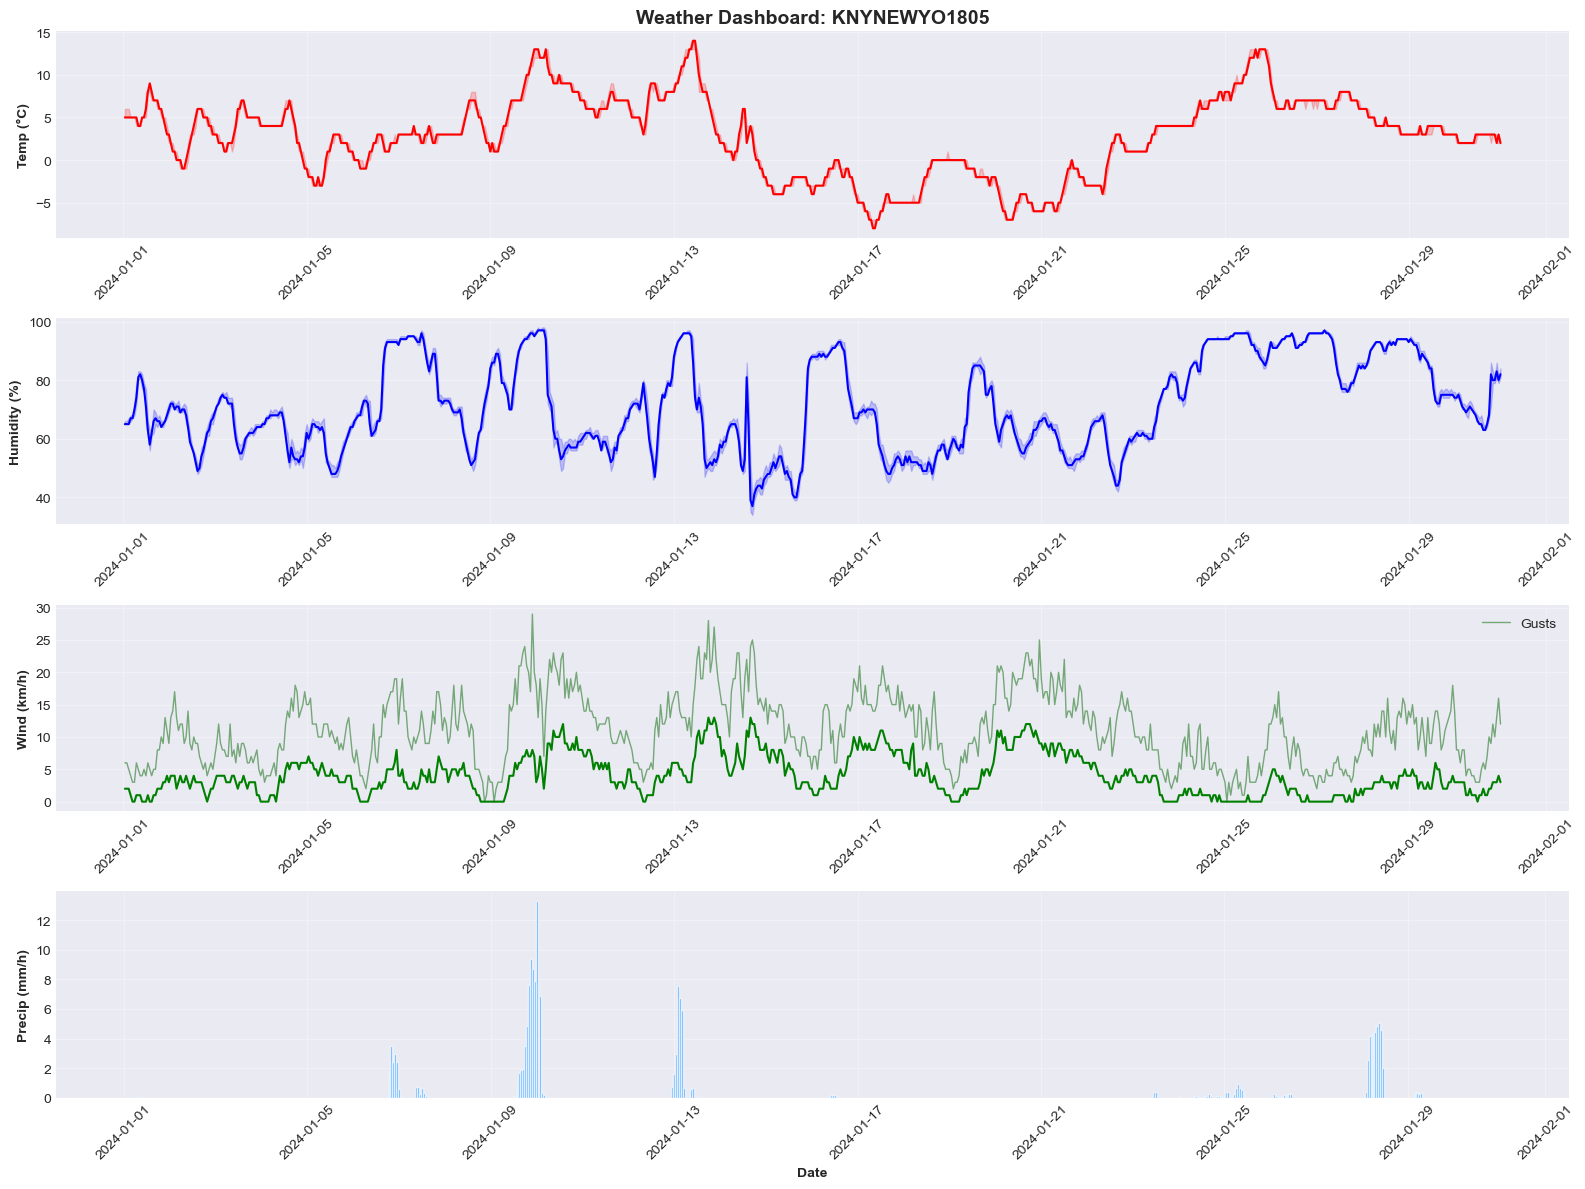

In [10]:
if 'df' in locals() and len(df) > 0:
    fig, axes = plt.subplots(4, 1, figsize=(16, 12))
    
    # Temperature
    if 'temp_avg' in df.columns:
        axes[0].plot(df['time_local'], df['temp_avg'], linewidth=1.5, color='red')
        axes[0].fill_between(df['time_local'], df['temp_low'], df['temp_high'], alpha=0.2, color='red')
        axes[0].set_ylabel('Temp (°C)' if UNITS == 'm' else 'Temp (°F)', fontweight='bold')
        axes[0].set_title(f'Weather Dashboard: {STATION_IDS[0]}', fontsize=14, fontweight='bold')
        axes[0].grid(True, alpha=0.3)
    
    # Humidity
    if 'humidity_avg' in df.columns:
        axes[1].plot(df['time_local'], df['humidity_avg'], linewidth=1.5, color='blue')
        axes[1].fill_between(df['time_local'], df['humidity_low'], df['humidity_high'], alpha=0.2, color='blue')
        axes[1].set_ylabel('Humidity (%)', fontweight='bold')
        axes[1].grid(True, alpha=0.3)
    
    # Wind
    if 'wind_speed_avg' in df.columns:
        axes[2].plot(df['time_local'], df['wind_speed_avg'], linewidth=1.5, color='green')
        axes[2].plot(df['time_local'], df['wind_gust_high'], linewidth=1, color='darkgreen', alpha=0.5, label='Gusts')
        axes[2].set_ylabel('Wind (km/h)' if UNITS == 'm' else 'Wind (mph)', fontweight='bold')
        axes[2].legend(loc='upper right')
        axes[2].grid(True, alpha=0.3)
    
    # Precipitation
    if 'precip_rate' in df.columns:
        axes[3].bar(df['time_local'], df['precip_rate'], width=0.04, color='dodgerblue' , alpha=0.7)
        axes[3].set_ylabel('Precip (mm/h)' if UNITS == 'm' else 'Precip (in/h)', fontweight='bold')
        axes[3].set_xlabel('Date', fontweight='bold')
        axes[3].grid(True, alpha=0.3)
    
    for ax in axes:
        ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
else:
    print("❌ No data for dashboard")

---
## 7. Export Data
---

In [11]:
# ============================================================================
# EXPORT DATA
# ============================================================================

if 'df' in locals() and len(df) > 0:
    print("💾 EXPORTING DATA")
    print("=" * 70)

    # Create output directory if it doesn't exist
    import os
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    print(f"📁 Output directory: {OUTPUT_DIR}")
    
    date_str = f"{start.strftime('%Y%m%d')}_{end.strftime('%Y%m%d')}"
    
    # CSV - Clean data
    csv_file = f'{OUTPUT_DIR}/weather_clean_{date_str}.csv'
    df.to_csv(csv_file, index=False)
    print(f"✅ CSV: {csv_file}")
    
    # CSV - Precipitation only
    precip_cols = ['time_local', 'precip_rate', 'precip_total']
    available = [c for c in precip_cols if c in df.columns]
    if len(available) > 0:
        precip_file = f'{OUTPUT_DIR}/precipitation_{date_str}.csv'
        df[available].to_csv(precip_file, index=False)
        print(f"✅ Precipitation CSV: {precip_file}")
    
    # JSON - All data
    if all_data:
        json_file = f'weather_all_{date_str}.json'
        save_to_json(all_data, json_file, OUTPUT_DIR)
    
    # Metadata
    if 'metadata' in locals():
        meta_file = f'{OUTPUT_DIR}/metadata_{date_str}.csv'
        metadata.to_csv(meta_file, index=False)
        print(f"✅ Metadata: {meta_file}")
    
    print("\n" + "=" * 70)
    print("✅ ALL DONE!")
    print("=" * 70)
else:
    print("❌ No data to export")

💾 EXPORTING DATA
📁 Output directory: output
✅ CSV: output/weather_clean_20240101_20240130.csv
✅ Precipitation CSV: output/precipitation_20240101_20240130.csv
✓ Data saved to output/weather_all_20240101_20240130.json
✅ Metadata: output/metadata_20240101_20240130.csv

✅ ALL DONE!


---
## Quick Reference
---

### DataFrames Available:
- `df_raw` - Original WU column names
- `df_clean` or `df` - Clean names (precipitation first!)
- `metadata` - Column descriptions

### Key Columns (Clean Names):
- `precip_rate` - Precipitation rate (mm/h or in/h)
- `precip_total` - Total precipitation (mm or in)
- `temp_avg` - Average temperature
- `humidity_avg` - Average humidity (%)
- `wind_speed_avg` - Average wind speed
- `time_local` - Local observation time

### Quick Commands:
```python
# View precipitation data
df[['time_local', 'precip_rate', 'precip_total']].head()

# Find rainy hours
df[df['precip_rate'] > 0]

# Daily totals
df.groupby(df['time_local'].dt.date)['precip_total'].sum()

# Plot temperature
df.plot(x='time_local', y='temp_avg', figsize=(14, 4))
```